# Wyznaczanie wierzchołków pasm materiałów na podłożu GaSb:

Materiał: GaAlSb  
Podłoże: GaSb

#### Imports:

In [32]:
import os, re
import numpy as np
from mendeleev import element
from collections import Counter

from src.material_analysis import material_type_checker, binary_compounds_decomposition 
from src.utils import roman_to_int, param_reader

### Load material:

In [3]:
#material = 'GaAlGeSb'
material = 'AlGaSb'
ground_material = 'GaSb'

In [4]:
component_names = re.findall('[A-Z][^A-Z]*', material) 
print("Components: ", component_names)

Components:  ['Al', 'Ga', 'Sb']


In [5]:
material_type, material_type_extensive = material_type_checker(material)

print("Material type:", material_type)
print("Material type extensive:", material_type_extensive)

Material type: IIIA_VA
Material type extensive: IIIA_2_VA_1


In [6]:
compounds = binary_compounds_decomposition(material)
compounds

['AlSb', 'GaSb']

## Energy band characteristics:

### Band gaps in temperature of `300K` from mole fraction:

Read band gaps in `T=0K`:

In [7]:
def read_binary_compounds_param(components, params_file_path, param):
    """Reads parameter from files for given list of components. There need to be path provided (same for all components). Only parameter specified by the "param" will be read.

    Args:
        components (List[str]): List of the components names
        params_file_path (str): path to parameter files
        param (str): name of the parameter in the parameters files

    Returns:
        list: List of the parameter for each componenets
    """
    read_params = []
    for c in components:
        with open(os.path.join(params_file_path, c+".txt")) as f:
            lines = f.readlines()
            for line in lines:
                if line.split("=")[0]==param:
                    read_param_str = line.split("=")[1].split(" ")[0]
                    #print(read_param_str)
                    read_param_float = float(read_param_str)
                    read_params.append(read_param_float)

    return read_params

In [38]:
params_file_path = os.path.join(".", "materials", "binary_compounds")

def read_binary_compounds_band_gap(components, params_file_path):
    # read band gaps in Gamma, L and X points in Brillouin zone:
    points_names = ['gamma', 'x', 'l']
    egs_0k = []
    for point in points_names:
        egs_0k.append(read_binary_compounds_param(components, params_file_path, f'Eg_{point}_0K'))
    
    egs_0k = np.asarray(egs_0k)        
    
    min_eg_ids = np.argmin(egs_0k, axis=0)
    min_egs = [egs_0k[ind, i] for i, ind in enumerate(min_eg_ids)]
    min_eg_points = [points_names[ind] for ind in min_eg_ids]
    
    alphas, betas = [], []
    for compound, point in zip(compounds, points_names):
        alphas.append(read_binary_compounds_param([compound], params_file_path, f'alpha_{point}')[0])
        betas.append(read_binary_compounds_param([compound], params_file_path, f'beta_{point}')[0])
    
    # print(min_eg_points, min_egs)
    # print(f'Alpha param. (Varshni param.):\t', alphas)
    # print(f'Beta param. (Varshni param.):\t', betas)
    
    return min_egs, alphas, betas, min_eg_points
    
min_egs_0k, alphas, betas, min_eg_points = read_binary_compounds_band_gap(compounds, params_file_path)

Calculate the band gaps in `T=300K`:

In [41]:
def calculating_bandgaps_from_varshni_relation(eg_0k, a, b, t=300):
    eg_t = eg_0k-(a*t**2)/(t+b)
    return eg_t 
    
min_egs_300k = []
for eg, a, b in zip(min_egs_0k, alphas, betas):
    min_egs_300k.append(calculating_bandgaps_from_varshni_relation(eg, a, b, t=300))

compounds, min_egs_300k

(['AlSb', 'GaSb'], [1.610090909090909, 0.703497461928934])

Import simulation method:

In [16]:
import importlib

try:
    libname = ".".join(["src", "simulations", material_type])
    simulation = importlib.import_module(libname)
    simulation = importlib.reload(simulation)
except ImportError:
    simulation = None
    print(f'Simulation method for \'{material_type}\' not implemented.')
else:
    globals()[libname] = simulation

In [17]:
x, Eg_x = simulation.band_gap_from_mole_fraction(band_gaps, material_type_extensive, method="VCA", points=3)

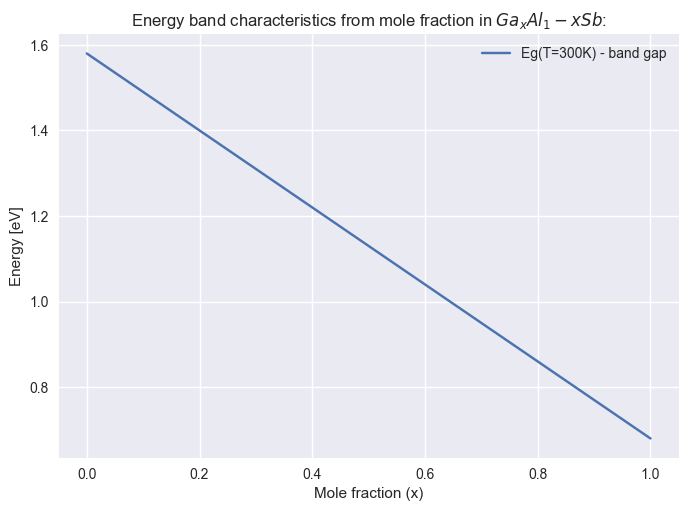

In [18]:
import matplotlib.pyplot as plt


with plt.style.context("seaborn"):
    plt.plot(x, Eg_x, '-', label='Eg(T=300K) - band gap')
    plt.title(r'Energy band characteristics from mole fraction in ${}_x{}_{a}{}$:'.format(*component_names, a="1-x"))
    plt.ylabel("Energy [eV]")
    plt.xlabel("Mole fraction (x)")
    plt.legend()
    plt.show()